In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# --- imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

# LightGBM & XGBoost
import lightgbm as lgb
import xgboost as xgb

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "creditcard.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

#print("First 5 records:", df.head())

In [ ]:
df.describe()

In [ ]:
MODELS_DIR = 'models'
os.makedirs(MODELS_DIR, exist_ok=True)

In [ ]:
def save_fig(fig, name, dpi=150):
    out = os.path.join('outputs', name)
    os.makedirs('outputs', exist_ok=True)
    fig.savefig(out, bbox_inches='tight', dpi=dpi)


def plot_class_distribution(y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    counts = pd.Series(y).value_counts().sort_index()
    labels = ['Non-fraud (0)', 'Fraud (1)']
    ax.bar(range(len(counts)), counts.values)
    ax.set_xticks([0,1]); ax.set_xticklabels(labels)
    ax.set_yscale('log')
    ax.set_ylabel('Count (log scale)')
    ax.set_title('Class distribution (log scale)')
    return ax


def plot_amount_distribution(df):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].hist(df['Amount'], bins=100); axes[0].set_title('Amount (raw)')
    axes[1].hist(np.log1p(df['Amount']), bins=100); axes[1].set_title('Log(Amount + 1)')
    return fig


def plot_time_by_class(df, bins=100):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(df[df['Class']==0]['Time'], bins=bins, alpha=0.6, label='Non-fraud')
    ax.hist(df[df['Class']==1]['Time'], bins=bins, alpha=0.6, label='Fraud')
    ax.set_title('Transaction Time (seconds since first transaction)')
    ax.legend()
    return fig


def precision_recall_summary(y_true, y_scores, plot=True, name=None):
    ap = average_precision_score(y_true, y_scores)
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    if plot:
        fig, ax = plt.subplots(figsize=(6,5))
        ax.plot(recall, precision, lw=2)
        ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall curve (AP={ap:.4f})')
        if name:
            save_fig(fig, name)
    return ap, precision, recall, thresholds

In [ ]:
print('Shape:', df.shape)
print(df.head())

# Basic info
print('\n--- Basic info ---')
print(df.info())

# ---------------------------
# EDA
# ---------------------------

print('\n=== EDA ===')
print('\nClass distribution:')
print(df['Class'].value_counts())

# class balance
n_total = len(df)
n_fraud = df['Class'].sum()
print(f"Total: {n_total}, Fraud: {n_fraud}, ratio: {n_fraud/n_total:.6f}")

# Plot class distribution
fig = plt.figure()
plot_class_distribution(df['Class'])
save_fig(fig, 'class_distribution.png')

# Amount distribution
fig = plot_amount_distribution(df)
save_fig(fig, 'amount_distribution.png')

# Time distribution by class
fig = plot_time_by_class(df)
save_fig(fig, 'time_by_class.png')

# Correlation heatmap for a sample (avoid plotting too large)
corr_sample = df.sample(min(5000, len(df)), random_state=42).corr()
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(corr_sample, cmap='RdBu', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_sample.columns)))
ax.set_xticklabels(corr_sample.columns, rotation=90, fontsize=8)
ax.set_yticks(range(len(corr_sample.columns)))
ax.set_yticklabels(corr_sample.columns, fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.02)
save_fig(fig, 'correlation_sample.png')

# Distribution of PCA features for fraud vs non-fraud (show a few)
pca_cols = [c for c in df.columns if c.startswith('V')]
show_cols = pca_cols[:6]
fig, axes = plt.subplots(2,3, figsize=(15,6))
for i, col in enumerate(show_cols):
    ax = axes.flatten()[i]
    ax.hist(df[df['Class']==0][col], bins=60, alpha=0.6, label='non-fraud')
    ax.hist(df[df['Class']==1][col], bins=60, alpha=0.6, label='fraud')
    ax.set_title(col)
    ax.legend()
save_fig(fig, 'pca_feature_dists.png')

print('EDA plots saved to outputs/')

In [ ]:
# Features & target
X = df.drop(columns=['Class'])
y = df['Class'].values

# Log transform Amount, keep Time as-is or apply scaling
X = X.copy()
X['Amount_log'] = np.log1p(X['Amount'])
X = X.drop(columns=['Amount'])

# Optional: scale Time and Amount_log
scaler = StandardScaler()
X[['Time', 'Amount_log']] = scaler.fit_transform(X[['Time', 'Amount_log']])

# Final feature matrix
feature_cols = X.columns.tolist()
print('Feature columns count:', len(feature_cols))

# Train / test split stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Save scaler and column list
joblib.dump(scaler, os.path.join(MODELS_DIR, 'scaler.joblib'))
pd.Series(feature_cols).to_csv(os.path.join(MODELS_DIR, 'feature_cols.csv'), index=False)

Feature columns count: 30
Train shape: (227845, 30) Test shape: (56962, 30)



Training baseline LogisticRegression (class_weight="balanced")...
LogisticRegression ROC-AUC: 0.9711, AP: 0.7135


(np.float64(0.7135422032569664),
 array([0.00172045, 0.00172048, 0.00172051, ..., 0.80357143, 0.8       ,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.45918367, 0.44897959,
        0.        ]),
 array([3.20054788e-26, 8.03787173e-26, 3.57315409e-24, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

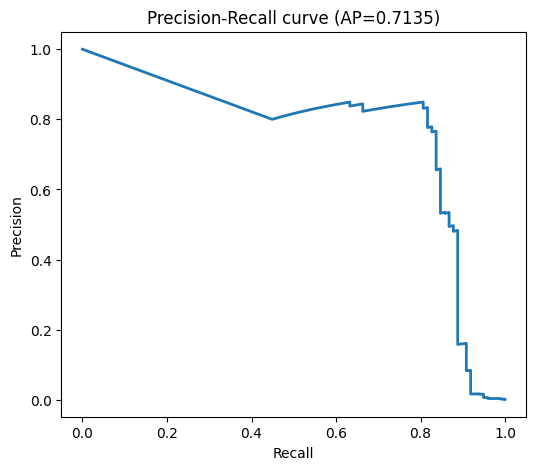

In [ ]:
print('\nTraining baseline LogisticRegression (class_weight="balanced")...')
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')
clf_lr.fit(X_train, y_train)

# Predict probabilities
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:,1]
roc_lr = roc_auc_score(y_test, y_pred_proba_lr)
ap_lr = average_precision_score(y_test, y_pred_proba_lr)
print(f'LogisticRegression ROC-AUC: {roc_lr:.4f}, AP: {ap_lr:.4f}')
joblib.dump(clf_lr, os.path.join(MODELS_DIR, 'logistic_baseline.joblib'))

precision_recall_summary(y_test, y_pred_proba_lr, plot=True, name='pr_lr.png')


Training LightGBM with Stratified KFold...
LightGBM Fold 1/5
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.974697	valid_1's auc: 0.848427
Early stopping, best iteration is:
[1]	training's auc: 0.952319	valid_1's auc: 0.909027
LightGBM Fold 2/5
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.975002	valid_1's auc: 0.860684
Early stopping, best iteration is:
[1]	training's auc: 0.966188	valid_1's auc: 0.907085
LightGBM Fold 3/5
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.917675	valid_1's auc: 0.807214
Early stopping, best iteration is:
[3]	training's auc: 0.971727	valid_1's auc: 0.909159
LightGBM Fold 4/5
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.993657	valid_1's auc: 0.810005
Early stopping, best iteration is:
[1]	training's auc: 0.95499	valid_1's auc: 0.953344
LightGBM Fold 5/5
Training until validation scores don't improve 

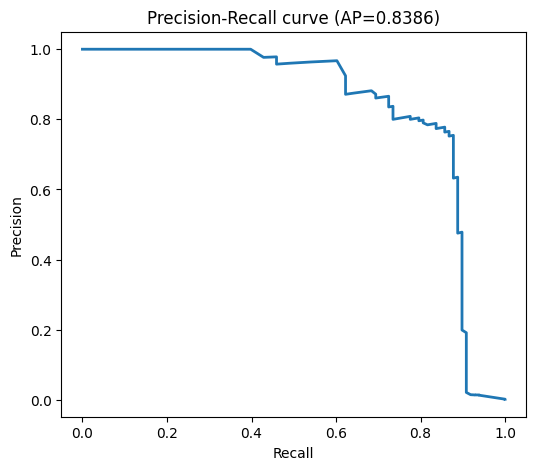

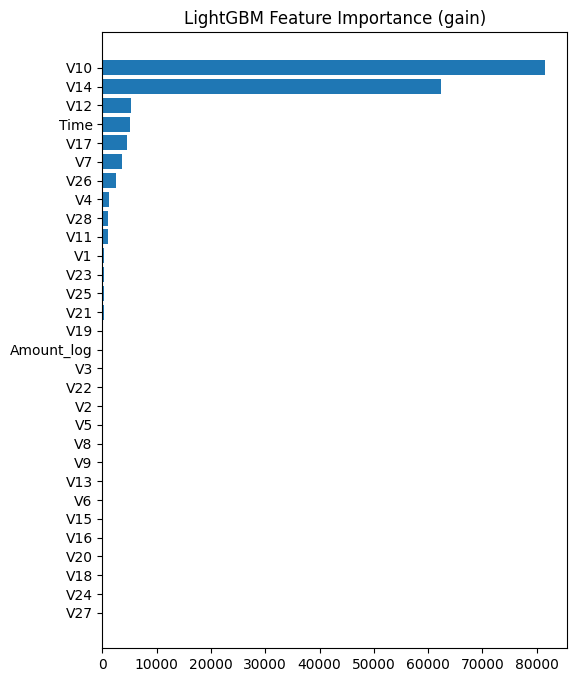

In [ ]:
print('\nTraining LightGBM with Stratified KFold...')

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'verbosity': -1,
}

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

lgb_oof = np.zeros(len(X_train))
lgb_preds = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'LightGBM Fold {fold+1}/{folds}')
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    train_set = lgb.Dataset(X_tr, label=y_tr)
    val_set = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        lgb_params,
        train_set,
        num_boost_round=2000,
        valid_sets=[train_set, val_set],
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
    )

    lgb_oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    lgb_preds += model.predict(X_test, num_iteration=model.best_iteration) / folds

# OOF metrics
roc_oof = roc_auc_score(y_train, lgb_oof)
ap_oof = average_precision_score(y_train, lgb_oof)
print(f'LightGBM OOF ROC-AUC: {roc_oof:.4f}, AP: {ap_oof:.4f}')

# Test metrics
roc_test = roc_auc_score(y_test, lgb_preds)
ap_test = average_precision_score(y_test, lgb_preds)
print(f'LightGBM Test ROC-AUC: {roc_test:.4f}, AP: {ap_test:.4f}')

# Save final model (retrain on full train set with best num_boost_round)
final_lgb = lgb.train(
    lgb_params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=int(model.best_iteration * 1.0)
)
final_lgb.save_model(os.path.join(MODELS_DIR, 'lightgbm_full.txt'))

precision_recall_summary(y_test, lgb_preds, plot=True, name='pr_lgb.png')

# Feature importance
fi = pd.DataFrame({'feature': feature_cols, 'importance': final_lgb.feature_importance(importance_type='gain')})
fi = fi.sort_values('importance', ascending=False).head(30)
fig, ax = plt.subplots(figsize=(6,8))
ax.barh(fi['feature'][::-1], fi['importance'][::-1])
ax.set_title('LightGBM Feature Importance (gain)')
save_fig(fig, 'lgb_feature_importance.png')


Training XGBoost with Stratified KFold...
XGBoost Fold 1/5
[0]	train-auc:0.95412	valid-auc:0.95053
[100]	train-auc:0.99993	valid-auc:0.98997
[200]	train-auc:1.00000	valid-auc:0.99357
[300]	train-auc:1.00000	valid-auc:0.99550
[400]	train-auc:1.00000	valid-auc:0.99606
[500]	train-auc:1.00000	valid-auc:0.99594
[553]	train-auc:1.00000	valid-auc:0.99580
XGBoost Fold 2/5
[0]	train-auc:0.97353	valid-auc:0.94869
[100]	train-auc:0.99994	valid-auc:0.97634
[144]	train-auc:1.00000	valid-auc:0.97699
XGBoost Fold 3/5
[0]	train-auc:0.95759	valid-auc:0.93920
[100]	train-auc:0.99990	valid-auc:0.97699
[137]	train-auc:0.99999	valid-auc:0.97526
XGBoost Fold 4/5
[0]	train-auc:0.95870	valid-auc:0.96933
[100]	train-auc:0.99992	valid-auc:0.99371
[200]	train-auc:1.00000	valid-auc:0.99421
[300]	train-auc:1.00000	valid-auc:0.99425
[347]	train-auc:1.00000	valid-auc:0.99439
XGBoost Fold 5/5
[0]	train-auc:0.96065	valid-auc:0.92687
[100]	train-auc:0.99995	valid-auc:0.97577
[175]	train-auc:1.00000	valid-auc:0.97620


(np.float64(0.8700201438337837),
 array([0.00172045, 0.00172048, 0.00172051, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.02040816, 0.01020408,
        0.        ]),
 array([1.09155260e-04, 1.09234004e-04, 1.09241201e-04, ...,
        9.42786708e-01, 9.43731204e-01, 9.46957618e-01]))

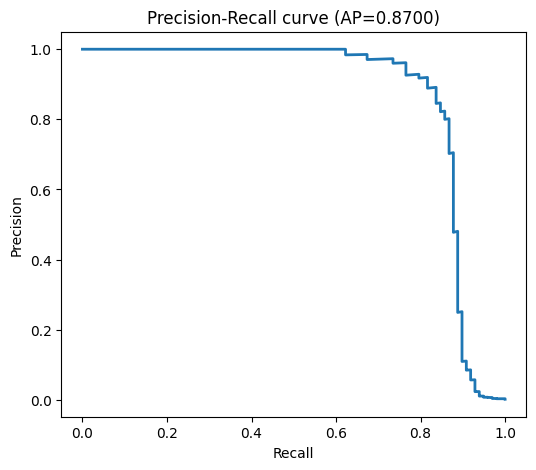

In [ ]:
print('\nTraining XGBoost with Stratified KFold...')

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'verbosity': 0,
}

xgb_oof = np.zeros(len(X_train))
xgb_preds = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'XGBoost Fold {fold+1}/{folds}')
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    watchlist = [(dtrain, 'train'), (dval, 'valid')]

    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=2000,
        evals=watchlist,
        early_stopping_rounds=100,
        verbose_eval=100,
    )

    xgb_oof[val_idx] = bst.predict(dval, iteration_range=(0, bst.best_iteration))
    xgb_preds += bst.predict(dtest, iteration_range=(0, bst.best_iteration)) / folds

roc_oof_xgb = roc_auc_score(y_train, xgb_oof)
ap_oof_xgb = average_precision_score(y_train, xgb_oof)
print(f'XGBoost OOF ROC-AUC: {roc_oof_xgb:.4f}, AP: {ap_oof_xgb:.4f}')

roc_test_xgb = roc_auc_score(y_test, xgb_preds)
ap_test_xgb = average_precision_score(y_test, xgb_preds)
print(f'XGBoost Test ROC-AUC: {roc_test_xgb:.4f}, AP: {ap_test_xgb:.4f}')

# Save XGBoost model (save the booster as binary)
bst.save_model(os.path.join(MODELS_DIR, 'xgboost_full.model'))

precision_recall_summary(y_test, xgb_preds, plot=True, name='pr_xgb.png')

In [ ]:
results = {
    'model': ['logistic', 'lightgbm', 'xgboost'],
    'roc_auc': [roc_lr, roc_test, roc_test_xgb],
    'average_precision': [ap_lr, ap_test, ap_test_xgb]
}
results_df = pd.DataFrame(results)
print('\nModel comparison:')
print(results_df)
results_df.to_csv(os.path.join(MODELS_DIR, 'model_comparison.csv'), index=False)

# Save test predictions for later analysis
preds_df = pd.DataFrame({
    'y_true': y_test,
    'proba_logistic': y_pred_proba_lr,
    'proba_lightgbm': lgb_preds,
    'proba_xgboost': xgb_preds,
})
preds_df.to_csv(os.path.join(MODELS_DIR, 'test_predictions.csv'), index=False)

# Save feature columns again
pd.Series(feature_cols).to_csv(os.path.join(MODELS_DIR, 'feature_cols.csv'), index=False)

print('\nAll models and outputs saved to models/ and outputs/')


Model comparison:
      model   roc_auc  average_precision
0  logistic  0.971113           0.713542
1  lightgbm  0.963068           0.838613
2   xgboost  0.976652           0.870020

All models and outputs saved to models/ and outputs/


In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Load predictions
df = pd.read_csv("models/test_predictions.csv")

y_true = df["y_true"]

model_cols = {
    "logistic": "proba_logistic",
    "lightgbm": "proba_lightgbm",
    "xgboost": "proba_xgboost"
}

# Pick a threshold
threshold = 0.5

for model_name, col in model_cols.items():
    # Convert probabilities to binary predictions
    y_pred = (df[col] >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"\n=== {model_name.upper()} ===")
    print(f"Total frauds in test set: {tp + fn}")
    print(f"Frauds correctly predicted (TP): {tp}")
    print(f"Frauds missed (FN): {fn}")
    print(f"False alarms (FP): {fp}")
    print(f"Recall (catch rate): {tp / (tp + fn):.3f}")



=== LOGISTIC ===
Total frauds in test set: 98
Frauds correctly predicted (TP): 90
Frauds missed (FN): 8
False alarms (FP): 1477
Recall (catch rate): 0.918

=== LIGHTGBM ===
Total frauds in test set: 98
Frauds correctly predicted (TP): 86
Frauds missed (FN): 12
False alarms (FP): 40
Recall (catch rate): 0.878

=== XGBOOST ===
Total frauds in test set: 98
Frauds correctly predicted (TP): 78
Frauds missed (FN): 20
False alarms (FP): 6
Recall (catch rate): 0.796
